In [3]:
import os, sys

import pandas as pd
import config_readwrite as crw
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import warnings
warnings.filterwarnings("ignore")
import plot_params as pp

pp.fonts()

('sans-serif', 'Arial', 18)

In [4]:
# read
config, cfn = crw.read(os.path.join(os.path.dirname(os.getcwd()), "config.ini"))

# load data

In [5]:
CL = "HEPG2"
DATAHEPG2 = config["data"][f'{CL}.clean.transformed'] 

CL = "BJ"
DATABJ = config["data"][f'{CL}.clean.transformed'] 

In [6]:
def openAndFilter(file_name):
    df = pd.read_csv(file_name, sep='\t')  # (58333, 38)
    print("before filtering", file_name,  df.shape)
    df = df.loc[~df["label"].str.contains("Synthetic")].reset_index(
        drop=True)  # (26803, 38)
    print("filter out synthetics", df.shape)
    df = df.loc[~df["label"].str.contains("Pos")].reset_index(
        drop=True)  # (26659, 38)
    print("filter out positive controls", df.shape, '\n\n')

    return df

In [7]:
hepg2 = openAndFilter(DATAHEPG2)
bj = openAndFilter(DATABJ)

before filtering /wynton/home/ahituv/fongsl/EMF/US/data/HepG2/full_hepg2_MPRA.clean.transformed.csv (58617, 34)
filter out synthetics (26998, 34)
filter out positive controls (26852, 34) 


before filtering /wynton/home/ahituv/fongsl/EMF/US/data/BJ/full_bj_MPRA.clean.transformed.csv (58333, 38)
filter out synthetics (26803, 38)
filter out positive controls (26659, 38) 




## keep only sequences tested in both cell types

In [9]:
joint = set(hepg2["name"]).intersection(set(bj["name"]))
print(len(joint))

# keep only data that is in both 
hepg2 = hepg2.loc[hepg2["name"].isin(joint)]
bj = bj.loc[bj["name"].isin(joint)]

26579


In [10]:
# relabel h3k27ac in type column
def relabelH3K27(df):
    df.loc[df.label.str.contains("27"), "type"] = "h3k27ac"
    return df

# label direction and change between US and CTRL


def labelDirection(df):
    """label sequences with different directions of change between US and Control
    note

    negative.higherUS == US MPRA activity is negative, but less negative than CTRL MPRA activity, which is also negative
    positive.higherUS  == US MPRA activity is positive and more positive than CTRL MPRA activity, which is also positive. 
    Positive.negatibe.higherUS == US activity is positive and higher than CTRL MPRA activity, which is negative. 
    """
    df["direction"] = None

    # Positive values only
    df.loc[(df["l2.ratio.mean.us"] > 0) &
           (df["l2.ratio.mean.ctrl"] > 0) &
           (df["delta.mean"] > 0),
           "direction"] = "Positive.higherUS"

    df.loc[(df["l2.ratio.mean.us"] > 0) &
           (df["l2.ratio.mean.ctrl"] > 0) &
           (df["delta.mean"] < 0),
           "direction"] = "Positive.higherCTRL"

    # Negtaive values only
    df.loc[(df["l2.ratio.mean.us"] < 0) &
           (df["l2.ratio.mean.ctrl"] < 0) &
           (df["delta.mean"] > 0),
           "direction"] = "Negative.higherUS"

    df.loc[(df["l2.ratio.mean.us"] < 0) &
           (df["l2.ratio.mean.ctrl"] < 0) &
           (df["delta.mean"] < 0),
           "direction"] = "Negative.higherCTRL"

    # crossing zero values only
    df.loc[(df["l2.ratio.mean.us"] > 0) &
           (df["l2.ratio.mean.ctrl"] < 0) &
           (df["delta.mean"] > 0),
           "direction"] = "Positive.Negative.higherUS"

    df.loc[(df["l2.ratio.mean.us"] < 0) &
           (df["l2.ratio.mean.ctrl"] > 0) &
           (df["delta.mean"] < 0),
           "direction"] = "Positive.Negative.higherCTRL"

    print(df.loc[df["direction"] != None, ["l2.ratio.mean.ctrl",
          "l2.ratio.mean.us", 'delta.mean', "direction"]].sample(n=20))
    return df


def labelActivity(df):
    """ label sequences as active if both conditions are positive"""
    df["activity"] = "~l2"
    df.loc[(df["l2.ratio.mean.us"] > 0) &
           (df["l2.ratio.mean.ctrl"] > 0),
           "activity"] = "l2>0"

    df.loc[(df["l2.ratio.mean.us"] < 0) &
           (df["l2.ratio.mean.ctrl"] < 0),
           "activity"] = "l2<0"

    print(df.groupby(["activity"])["name"].count())
    return df

In [11]:
for df in [bj, hepg2]:
    df = relabelH3K27(df)
    df = labelDirection(df)
    df = labelActivity(df)

       l2.ratio.mean.ctrl  l2.ratio.mean.us  delta.mean            direction
2392            -1.063615         -1.212594   -0.148979  Negative.higherCTRL
9012             0.298003          0.458545    0.160542    Positive.higherUS
25749           -0.073333         -0.077109   -0.003777  Negative.higherCTRL
8473             0.314587          0.295498   -0.019089  Positive.higherCTRL
17502            0.296121          0.323803    0.027682    Positive.higherUS
13862           -0.356745         -0.430747   -0.074003  Negative.higherCTRL
17966            0.433521          0.452741    0.019221    Positive.higherUS
10091           -0.437921         -0.340371    0.097550    Negative.higherUS
17363           -0.042725         -0.081448   -0.038723  Negative.higherCTRL
12253           -0.582211         -0.677092   -0.094882  Negative.higherCTRL
25411            0.177201          0.175079   -0.002123  Positive.higherCTRL
7271             0.130612          0.180152    0.049541    Positive.higherUS

# long-form PCA analysis

In [12]:
"""
X = df[['l2.ratio.1.ctrl',
        'l2.ratio.2.ctrl',
        'l2.ratio.3.ctrl',
        'l2.ratio.1.us',
        'l2.ratio.2.us',
        'l2.ratio.3.us']].copy().to_numpy()

ylabels = df[["label", "response", "cl.origin", "type", "delta.mean", "direction", "activity",
             'pval',
             'p_adj',
             'logFC',
             'response',]]


## scale data

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

## do PCA on scaled data

pca = PCA(n_components=4)
X_ = pca.fit_transform(X_scaled)

print(pca.explained_variance_ratio_) 

## combine PCA and labels

plot=pd.DataFrame(X_)
plot = pd.concat([plot,ylabels], axis=1)
set(ylabels)

x, y = 0,1
hue='activity'
hue_order = None
fig, ax= plt.subplots()
sns.scatterplot(x=x,y=y, data=plot, hue=hue, hue_order=hue_order, alpha=0.8)
ax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}", 
      ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio_[y], 2)}")

x, y = 0,1
hue='type'
hue_order = ['ATAC', 'DEG', 'NegCt', 
             #'PosCt', 
             'Shuffle', "h3k27ac"]
fig, ax= plt.subplots()
sns.scatterplot(x=x,y=y, data=plot, hue=hue, hue_order=hue_order, alpha=0.8)
ax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}", 
      ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio_[y], 2)}")

x, y = 1,2
hue='delta.mean'
fig, ax= plt.subplots()
sns.scatterplot(x=x,y=y, data=plot, hue=hue, alpha=0.8, palette="bwr", hue_order=hue_order)
ax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}", 
      ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio_[y], 2)}")
ax.legend(bbox_to_anchor =(1,1))

x, y = 2,3
hue = 'direction'
hue_order = ['Positive.higherUS', 
             'Negative.higherUS',
             'Positive.Negative.higherUS',
             'Positive.higherCTRL', 
             'Negative.higherCTRL',
             'Positive.Negative.higherCTRL',
             
            ]
fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, data=plot, hue=hue, alpha=0.8, hue_order=hue_order, palette = plt.cm.tab20b.colors[9:])
ax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}",
       ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio_[y], 2)}")
ax.legend(bbox_to_anchor =(1,1))

x, y = 2, 3
hue = 'pval'
hue_order=None
fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, data=plot, hue=hue, alpha=0.8, hue_order=hue_order)
ax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}",
       ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio_[y], 2)}")
ax.legend(bbox_to_anchor =(1,1))

x, y = 2, 3
hue = 'direction'
hue_order = ['Positive.higherUS',
             'Negative.higherUS',
             'Positive.Negative.higherUS',
             'Positive.higherCTRL',
             'Negative.higherCTRL',
             'Positive.Negative.higherCTRL',
             ]
fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, data=plot, hue=hue, alpha=0.8,
                hue_order=hue_order, palette=plt.cm.tab20b.colors[1:])
ax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}",
       ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio_[y], 2)}")
ax.legend(bbox_to_anchor=(1, 1))

x, y = 1, 2
hue = 'delta.mean'
# hue = "direction"
hue_order = None
fig, ax = plt.subplots()
sns.scatterplot(x=x, y=y, data=plot, hue=hue, alpha=0.8, palette='bwr')
ax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}",
       ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio_[y], 2)}")
ax.legend(bbox_to_anchor=(1, 1))
"""

'\nX = df[[\'l2.ratio.1.ctrl\',\n        \'l2.ratio.2.ctrl\',\n        \'l2.ratio.3.ctrl\',\n        \'l2.ratio.1.us\',\n        \'l2.ratio.2.us\',\n        \'l2.ratio.3.us\']].copy().to_numpy()\n\nylabels = df[["label", "response", "cl.origin", "type", "delta.mean", "direction", "activity",\n             \'pval\',\n             \'p_adj\',\n             \'logFC\',\n             \'response\',]]\n\n\n## scale data\n\nsc = StandardScaler()\nX_scaled = sc.fit_transform(X)\n\n## do PCA on scaled data\n\npca = PCA(n_components=4)\nX_ = pca.fit_transform(X_scaled)\n\nprint(pca.explained_variance_ratio_) \n\n## combine PCA and labels\n\nplot=pd.DataFrame(X_)\nplot = pd.concat([plot,ylabels], axis=1)\nset(ylabels)\n\nx, y = 0,1\nhue=\'activity\'\nhue_order = None\nfig, ax= plt.subplots()\nsns.scatterplot(x=x,y=y, data=plot, hue=hue, hue_order=hue_order, alpha=0.8)\nax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}", \n      ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio

# wide-form

## prepare the data with replicates

In [87]:
Xbj = bj[["name", 'l2.ratio.1.ctrl',
          'l2.ratio.2.ctrl',
          'l2.ratio.3.ctrl',
          'l2.ratio.1.us',
          'l2.ratio.2.us',
          'l2.ratio.3.us']].copy()

Xhepg2 = hepg2[["name", 'l2.ratio.1.ctrl',
                'l2.ratio.2.ctrl',
                'l2.ratio.3.ctrl',
                'l2.ratio.1.us',
                'l2.ratio.2.us',
                'l2.ratio.3.us']].copy()


ylabels = ['bj-l2.ratio.1.ctrl',
                   'bj-l2.ratio.2.ctrl',
                  'bj-l2.ratio.3.ctrl',
                   'bj-l2.ratio.1.us',
                   'bj-l2.ratio.2.us',
                   'bj-l2.ratio.3.us']

ylabels.extend(['hepg2-l2.ratio.1.ctrl',
                   'hepg2-l2.ratio.2.ctrl',
                  'hepg2-l2.ratio.3.ctrl',
                   'hepg2-l2.ratio.1.us',
                   'hepg2-l2.ratio.2.us',
                   'hepg2-l2.ratio.3.us'])

# merge, transpose, and turn into a numpy array. 
X = pd.merge(Xbj, Xhepg2, left_on="name", right_on="name").T.to_numpy()

## scale, fit transform data

In [88]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X[1:])

## do PCA on scaled data

pca = PCA(n_components=10)
X_ = pca.fit_transform(X_scaled)

print(pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum()) 

[0.33190597 0.08311987 0.07071877 0.07015628 0.06793986 0.06714848
 0.06528248 0.06378253 0.06124959 0.05958171] 0.9408855303797283


## scree plot

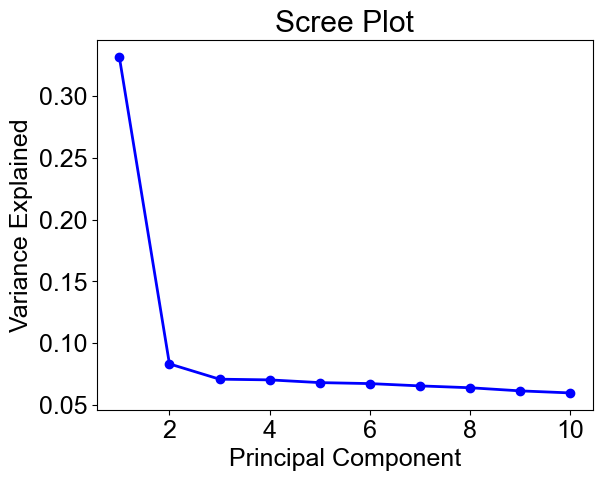

In [89]:
# from https://www.statology.org/scree-plot-python/

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [92]:
# make dataframe from result PCs
plot=pd.DataFrame(X_)

## combine PCA and labels
plot.index = ylabels
plot = plot.reset_index()
plot

,index,0,1,2,3,4,5,6,7,8,9
0,bj-l2.ratio.1.ctrl,-90.039992,-34.931415,126.565132,40.546502,8.054113,-4.346901,0.272213,-6.017941,-7.033499,-1.815130
1,bj-l2.ratio.2.ctrl,-83.868029,-31.124672,-4.032068,-88.843515,-69.671305,-35.571182,53.921746,-27.115690,2.400528,-1.392695
2,bj-l2.ratio.3.ctrl,-67.166563,-69.108351,-45.183348,-17.534992,98.162181,-35.421746,-28.900955,-26.574176,-7.830191,-11.974443
3,bj-l2.ratio.1.us,-134.793709,99.589134,-1.716210,-27.250358,51.857932,34.824437,34.927880,37.511773,12.242551,17.604275
4,bj-l2.ratio.2.us,-96.606692,16.219244,-57.161676,102.971326,-41.860283,-45.280372,16.756895,-1.682892,11.950409,-6.373933
5,bj-l2.ratio.3.us,-63.766809,-47.594322,-29.819785,1.968270,-40.024803,110.018825,-45.298639,11.345257,-11.188085,-7.331661
6,hepg2-l2.ratio.1.ctrl,49.337425,22.476262,12.400359,-26.719724,-24.029305,-49.889334,-75.298973,74.160573,2.660613,-33.941615
7,hepg2-l2.ratio.2.ctrl,140.361888,-49.150986,-8.800018,12.685425,18.466745,9.714626,77.223236,74.433061,-11.590864,-12.139921
8,hepg2-l2.ratio.3.ctrl,115.768621,2.616948,2.164957,14.347520,2.589417,11.102794,12.463841,-37.220811,-20.263359,64.081867
9,hepg2-l2.ratio.1.us,77.374777,61.002147,0.991175,-1.268603,-0.162070,5.965667,-1.895796,-53.619590,-80.755012,-60.329476


In [96]:
cmap = [
        "#61de2a",  "#61de2a",  "#61de2a", # toxic green
        "#388004", "#388004", "#388004", # dark grass green
        #"#a8ff04", "#a8ff04", "#a8ff04", # electric lime 

        "#966ebd", "#966ebd", "#966ebd", # deep lilac
        '#430541','#430541','#430541', # eggplant        
        
       ]

## pc1 v. pc2

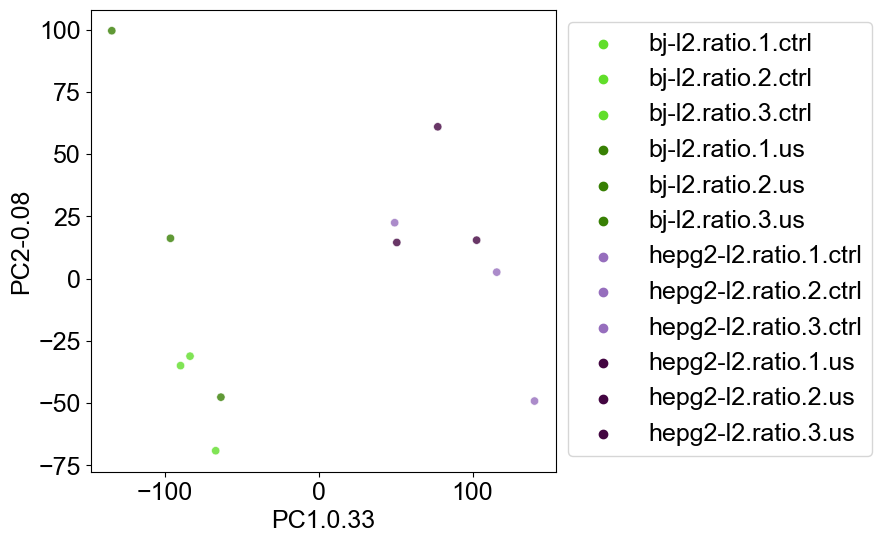

In [97]:
x, y = 0,1
hue="index"
hue_order = None
fig, ax= plt.subplots(figsize = (6,6))
sns.scatterplot(x=x,y=y, data=plot, hue=hue, hue_order=hue_order, alpha=0.8, palette=cmap,#plt.cm.tab20c.colors[:]
               )
ax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}", 
      ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio_[y], 2)}")
ax.legend(bbox_to_anchor =(1,1))

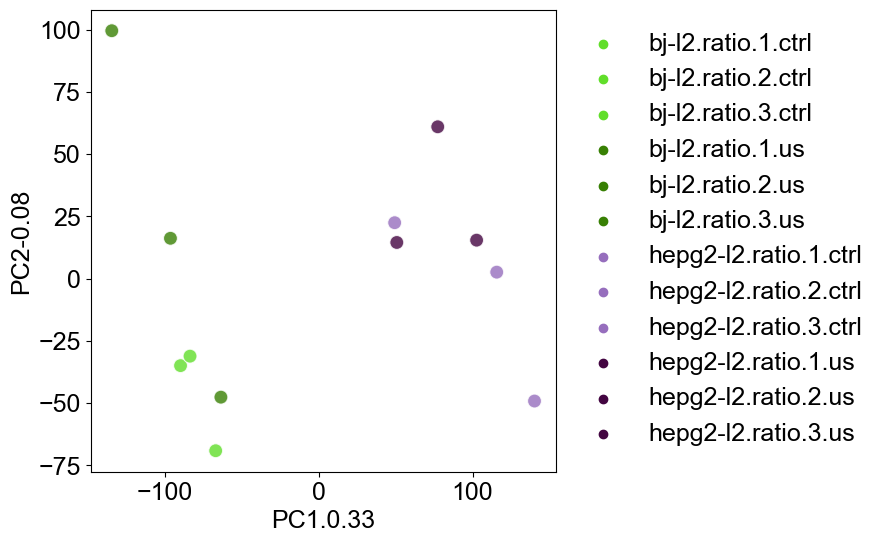

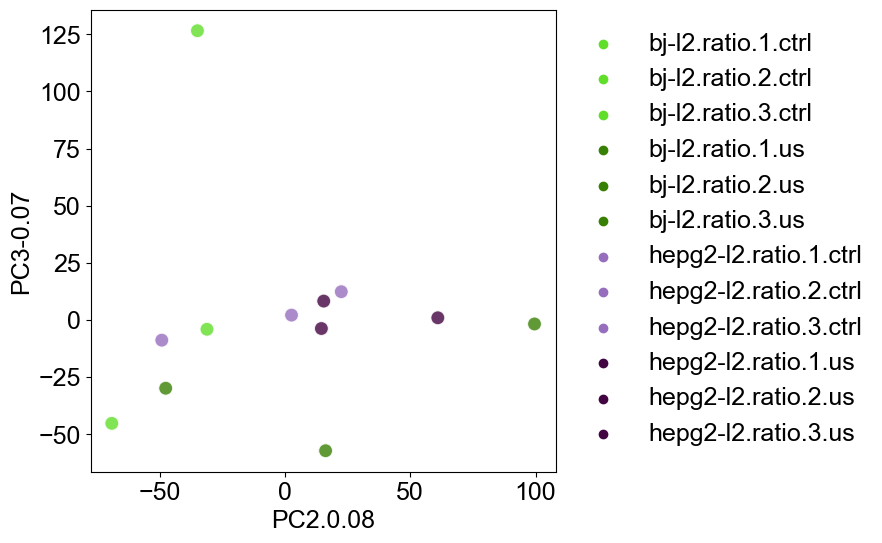

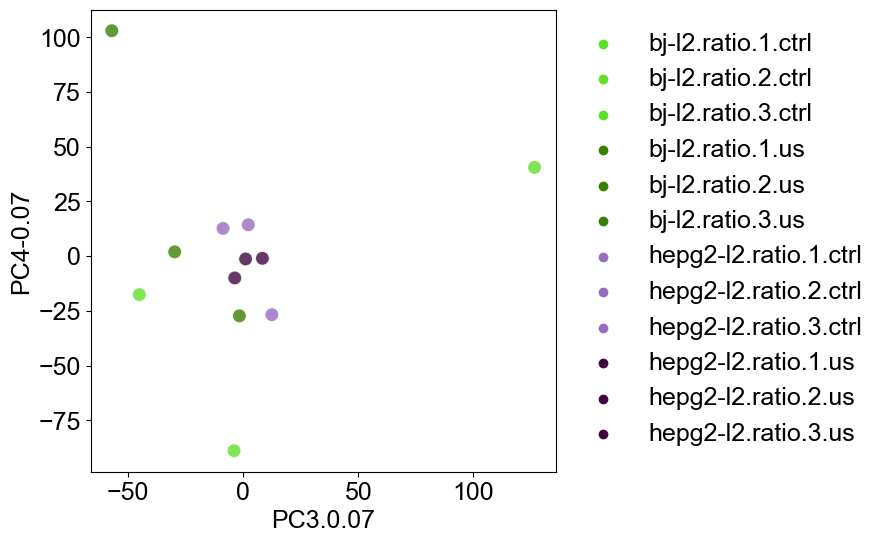

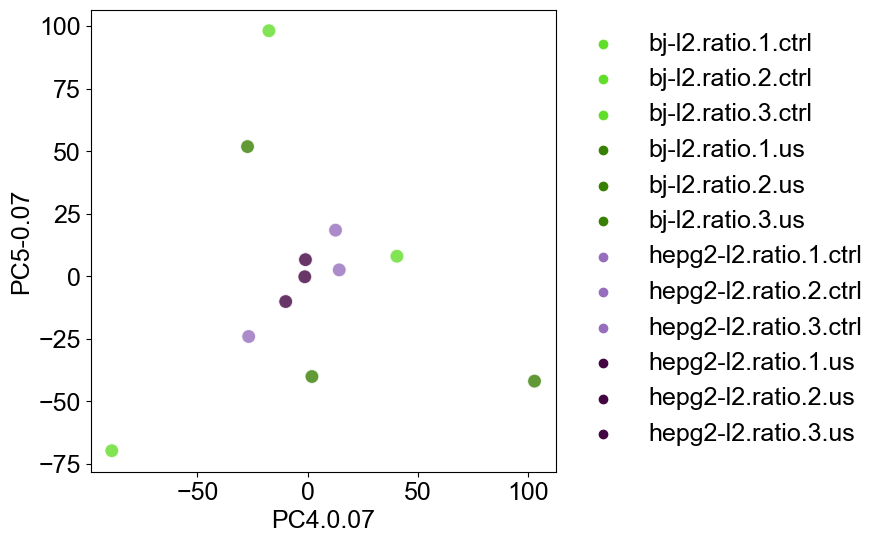

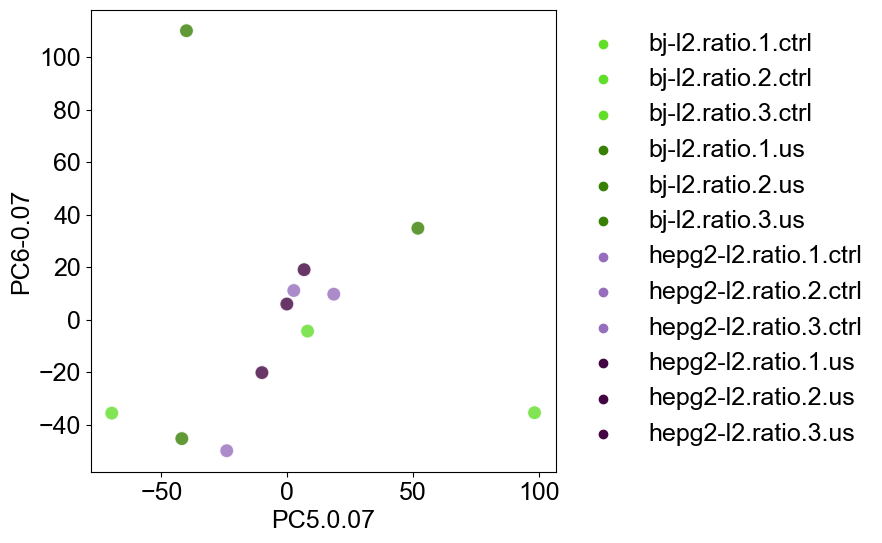

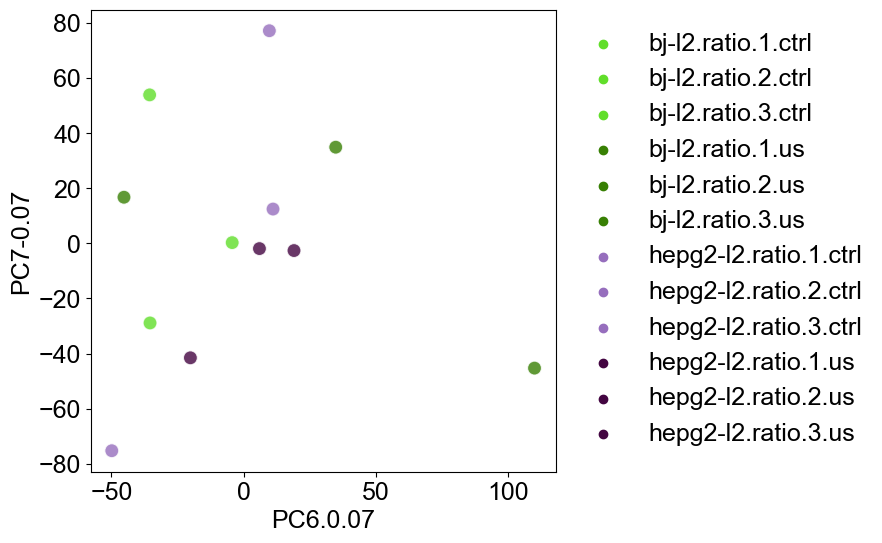

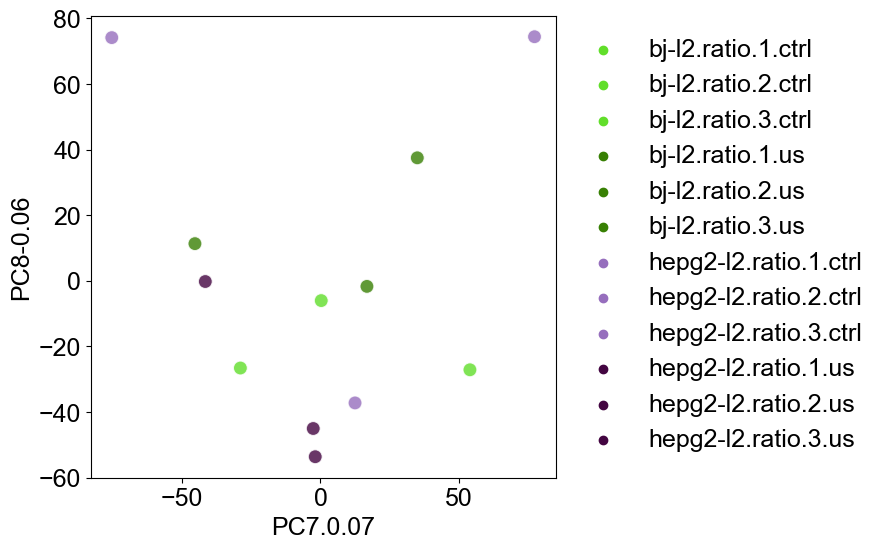

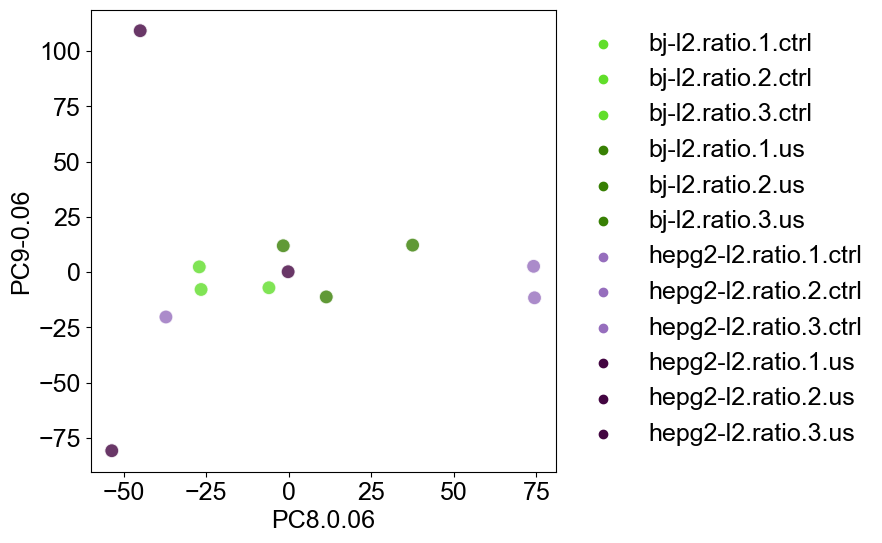

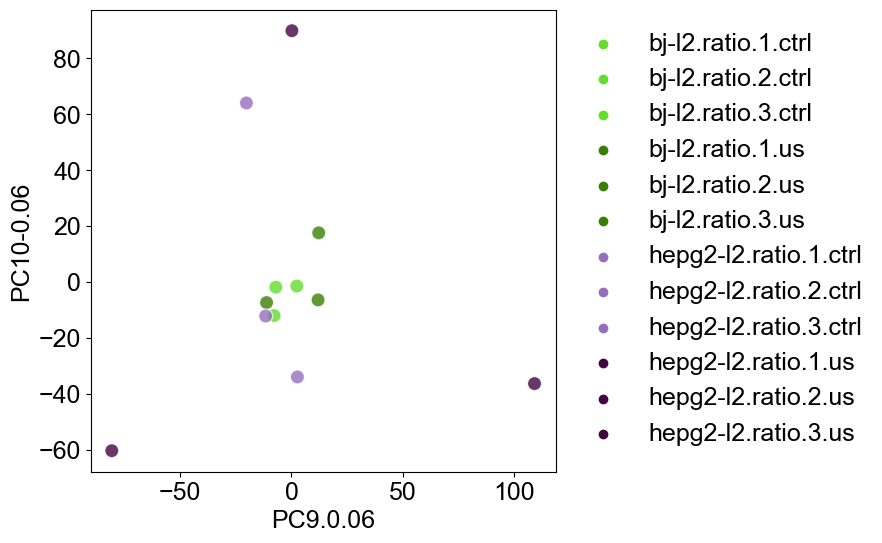

In [98]:
for i in np.arange(pca.n_components):
    if i!=pca.n_components-1:
        x, y = i,i+1
        hue="index"
        hue_order = None
        fig, ax= plt.subplots(figsize = (6,6))
        sns.scatterplot(x=x,y=y, data=plot, hue=hue, hue_order=hue_order, alpha=0.8, palette=cmap,
                        s=100
                       )
        ax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}", 
              ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio_[y], 2)}")
        ax.legend(bbox_to_anchor =(1,1), frameon=False)

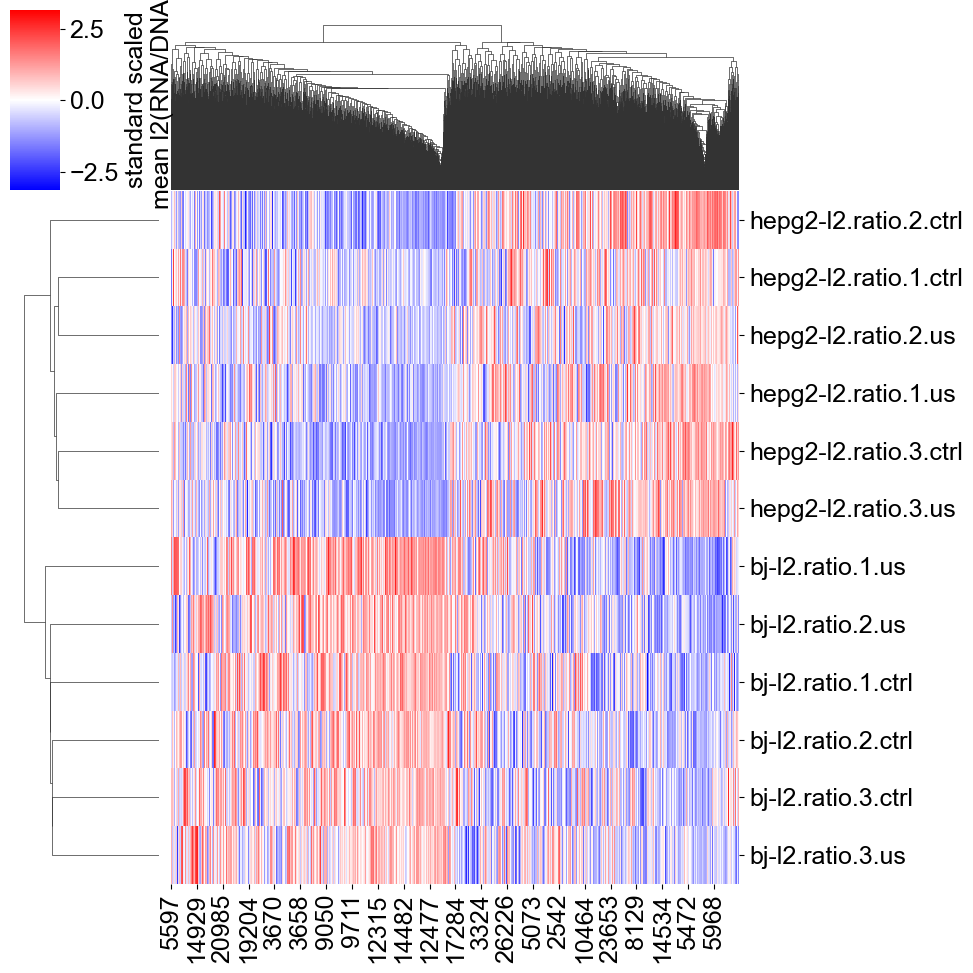

In [99]:
a = pd.DataFrame(X_scaled)
a.index=ylabels
sns.clustermap(a, cmap='bwr',
               cbar_kws={"label":"standard scaled\nmean l2(RNA/DNA)"}
              )

# summarized means

In [65]:
Xbj = bj[["name", 'l2.ratio.mean.ctrl',
          'l2.ratio.mean.us',
          ]].copy()

Xhepg2 = hepg2[["name", 
                'l2.ratio.mean.ctrl',
          'l2.ratio.mean.us']].copy()


ylabels = ['bj-l2.ratio.mean.ctrl',
                   'bj-l2.ratio.mean.us']

ylabels.extend(['hepg2-l2.ratio.mean.ctrl',
                   'hepg2-l2.ratio.mean.us'])

# merge, transpose, and turn into a numpy array. 
X = pd.merge(Xbj, Xhepg2, left_on="name", right_on="name").T.to_numpy()

In [66]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X[1:])

## do PCA on scaled data

pca = PCA(n_components=3)
X_ = pca.fit_transform(X_scaled)

print(pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum()) 

[0.59812727 0.21284339 0.18902933] 1.0000000000000004


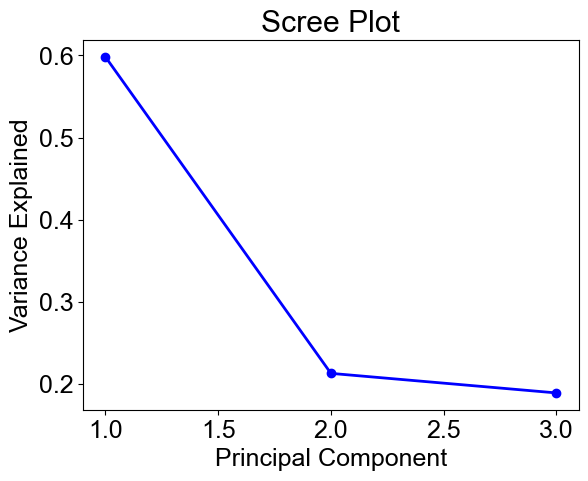

In [67]:
# from https://www.statology.org/scree-plot-python/

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [68]:
# make dataframe from result PCs
plot=pd.DataFrame(X_)

## combine PCA and labels
plot.index = ylabels
plot = plot.reset_index()
plot

,index,0,1,2
0,bj-l2.ratio.mean.ctrl,-112.529215,108.496548,24.825195
1,bj-l2.ratio.mean.us,-137.737507,-93.853978,-35.410605
2,hepg2-l2.ratio.mean.ctrl,143.012652,23.834661,-90.024177
3,hepg2-l2.ratio.mean.us,107.254070,-38.477231,100.609586


In [79]:
cmap = [
    "#61de2a",  # toxic green
    "#388004",  # dark grass green
    "#966ebd",  # deep lilac
    '#430541',  # eggplant
]

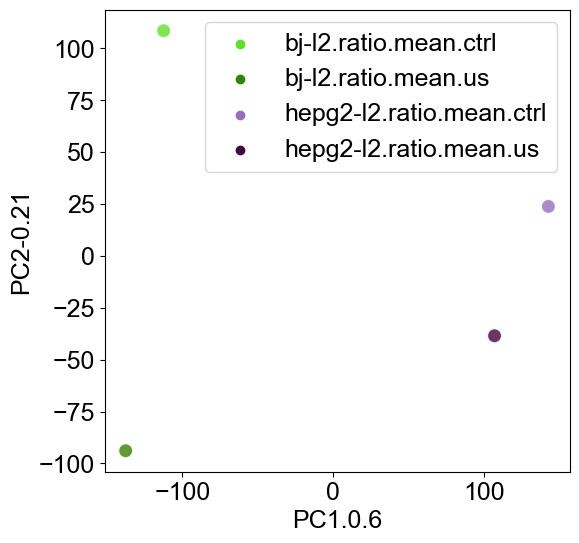

In [81]:
x, y = 0,1
hue="index"
hue_order = None
fig, ax= plt.subplots(figsize = (6,6))
sns.scatterplot(x=x,y=y, data=plot, hue=hue, hue_order=hue_order, alpha=0.8, palette=cmap,
                s=100
               )
ax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}", 
      ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio_[y], 2)}")
ax.legend(bbox_to_anchor =(1,1))

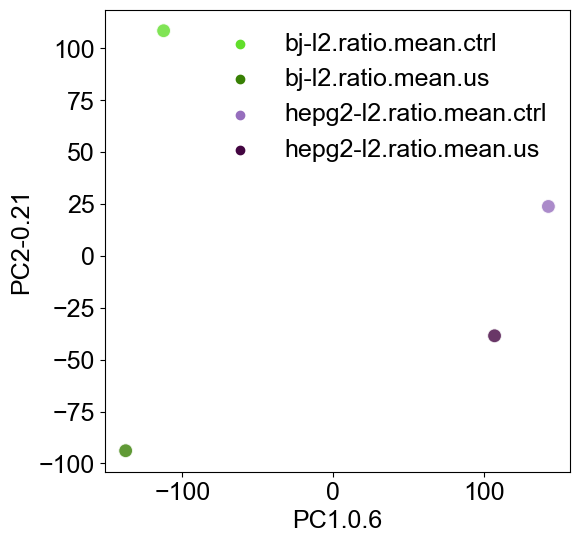

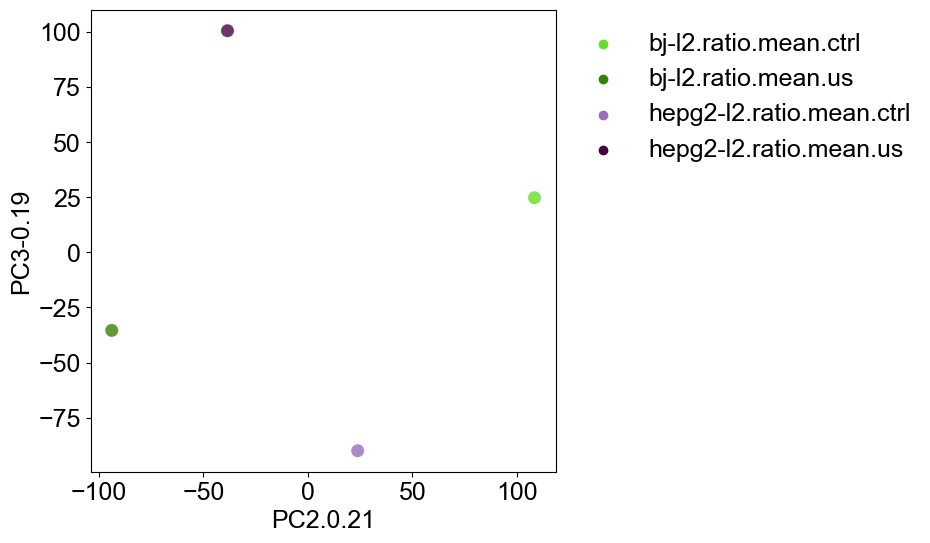

In [82]:
for i in np.arange(pca.n_components):
    if i != pca.n_components-1:
        x, y = i, i+1
        hue = "index"
        hue_order = None
        fig, ax = plt.subplots(figsize=(6, 6))
        sns.scatterplot(x=x, y=y, data=plot, hue=hue, hue_order=hue_order, alpha=0.8, palette=cmap,
                        s=100, 
                        )
        ax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}",
               ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio_[y], 2)}")
        ax.legend(bbox_to_anchor=(1, 1), frameon=False)

## cluster map

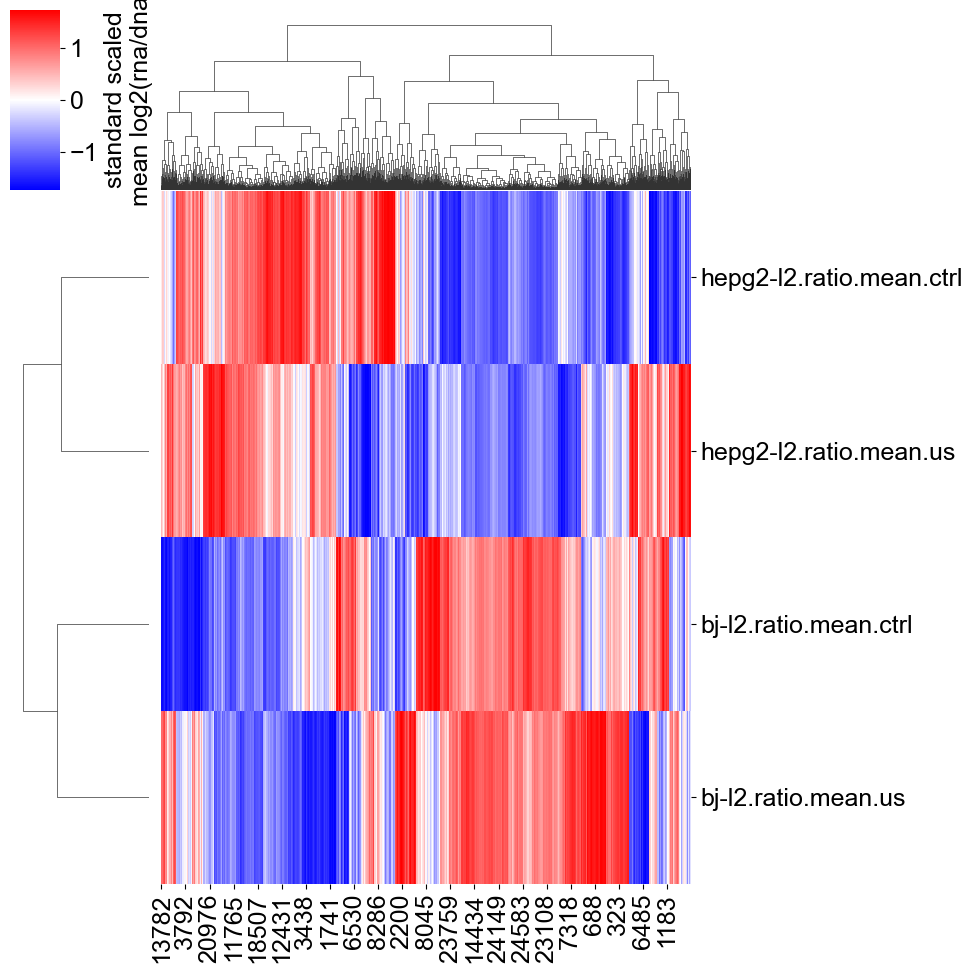

In [86]:
a = pd.DataFrame(X_scaled)
a.index = ylabels
sns.clustermap(a, cmap="bwr", cbar_kws={"label":"standard scaled\n mean log2(rna/dna)"})

In [ ]:
sns.clustermap